In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [3]:
tensor_transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root = "./data", train = True, download = True, transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 32, shuffle = True)

testset = datasets.FashionMNIST(root = "./data", train = False, download = True, transform = tensor_transform)
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1000, shuffle = False)

In [7]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## MLP

In [72]:
class AESimple(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # YOUR CODE
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, self.latent_dim),
            torch.nn.ReLU(),
            # torch.nn.Linear(self.latent_dim, self.latent_dim),
            # torch.nn.ReLU(),
        )
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(self.latent_dim, self.latent_dim),
            torch.nn.Linear(self.latent_dim, 28 * 28),
            torch.nn.Sigmoid(),
        )

        # YOUR CODE

    def forward(self, x):
        # YOUR CODE
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        reshaped = torch.reshape(decoded, (-1, 1, 28, 28))
        return reshaped

        # YOUR CODE

In [73]:
def train_eval(epochs, lr, model, loader, testloader):
    pelosses = []
    pelosses_test = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)

    for epoch in range(epochs):    
        peloss = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed = model(image)  
            loss = loss_function(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
        peloss /= len(loader)
        pelosses.append(peloss)
    
        pelosstest = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed = model(image)  
                pelosstest += loss_function(reconstructed, image).item()
            pelosstest /= len(testloader)
            pelosses_test.append(pelosstest)
        print("Epoch %i: %6.4f  %6.4f"%(epoch,peloss,pelosstest))
    return pelosses, pelosses_test

In [74]:
def plot_loss(pelosses, pelosses_test):
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    epochs = len(pelosses)
    plt.semilogy(torch.arange(epochs)+1, pelosses, 'b-')
    plt.semilogy(torch.arange(epochs)+1, pelosses_test, 'r-')    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 784]         101,136
           Sigmoid-5                  [-1, 784]               0
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.77
Estimated Total Size (MB): 0.79
----------------------------------------------------------------
Epoch 0: 0.0214  0.0115
Epoch 1: 0.0099  0.0087
Epoch 2: 0.0081  0.0077
Epoch 3: 0.0074  0.0073
Epoch 4: 0.0070  0.0070


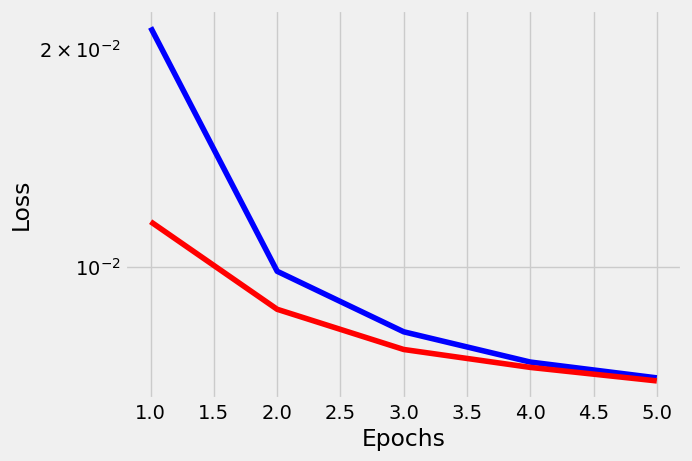

In [75]:
nepochs = 5
lin_model = AESimple(128)
summary(lin_model, (1,28,28), device="cpu")
pelosses, pelosses_test = train_eval(nepochs, 0.001, lin_model, loader, testloader)
plot_loss(pelosses, pelosses_test)

In [76]:
def reconstruct(img, model):
    img = model(img)
    return img

def plot_img(img, title):
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

def plot_samples(dataset, models):
    n = 10
    m = len(models)
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        for j in range(m):
            figure.add_subplot(rows, cols, (j+1)*n+i+1)
            img, label = dataset[idx]
            img = reconstruct(img, models[j].to("cpu")).detach().numpy()
            plot_img(img, "")
    
    plt.show()

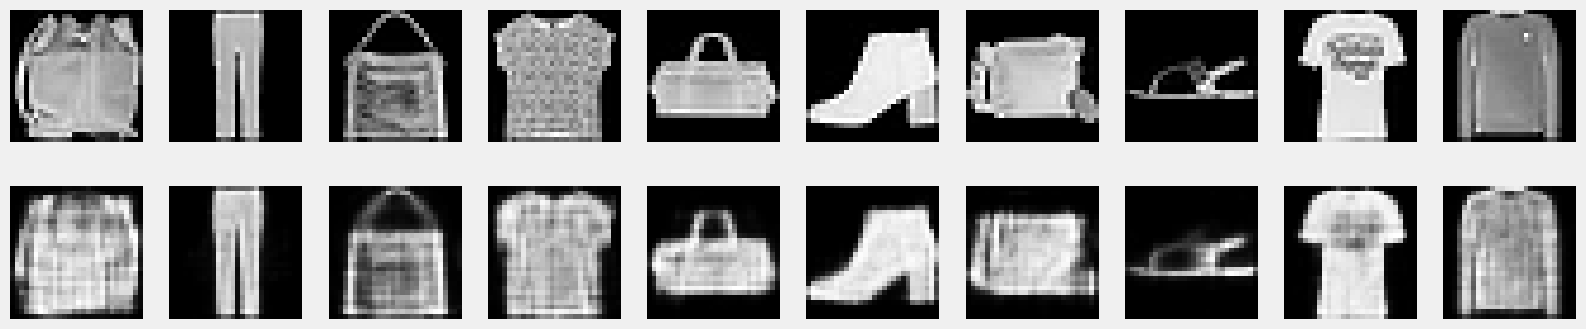

In [77]:
plot_samples(testset, [lin_model])

In [78]:
def interpolate(img1, img2, model, d):
    n = 20
    lrow = int(n/2)
    
    model = model.to("cpu")

    img1 = img1.view(-1,1,28*28)
    z1 = model.encoder(img1)
    
    z1 = z1.view(-1,d)
    rec1 = model.decoder(z1)
    img2 = img2.view(-1,28*28)
    z2 = model.encoder(img2)
    z2 = z2.view(-1,d)
    rec2 = model.decoder(z2)
    
    imgs = [img1.detach().numpy(), rec1.detach().numpy()]
    for i in range(n-4):
        z = z1 + (z2-z1)*i/(n-4)
        img_dist = model.decoder(z).detach().numpy()
        imgs.append(img_dist)

    imgs.append(rec2.detach().numpy())
    imgs.append(img2.detach().numpy())

    plt.figure(figsize=(18, 4))
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1)
        plot_img(imgs[i].reshape(28,28), "")
    
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1 + lrow)
        plot_img(imgs[lrow+i].reshape(28,28), "")

plt.show()

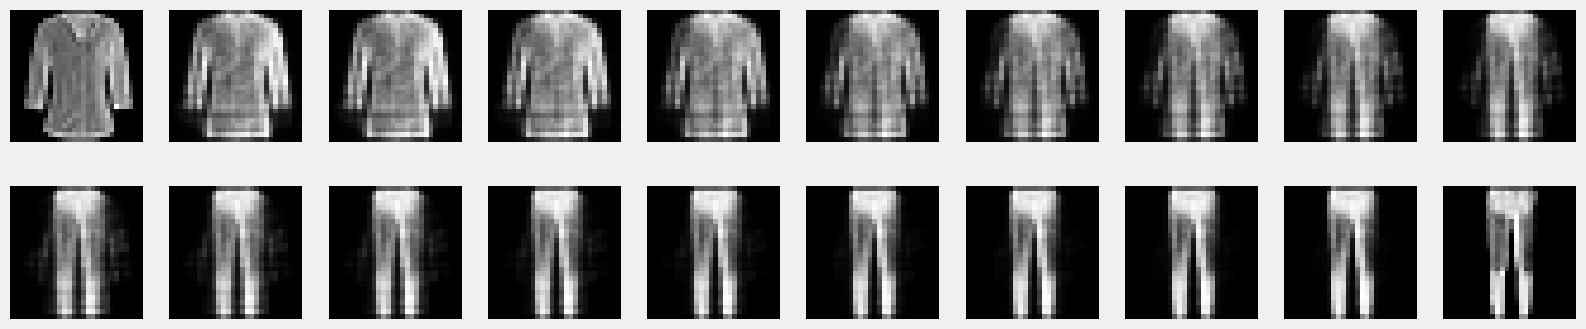

In [79]:
interpolate(testset[4][0], testset[3][0], lin_model, 128)

In [80]:
def noise_added(inputs, model, sigma=0.2):
    n = 10
    m = len(inputs)
    to_plot = {}
    model = model.to("cpu")
    for j in range(m):
        img = inputs[j]
        z = model.encoder(img)
        rec = model.decoder(z)    
        imgs = [img.detach().numpy(), rec.detach().numpy()]
        for i in range(n-2):
            noise = sigma*torch.randn((model.latent_dim,))
            img_dist = model.decoder(z+noise).detach().numpy()
            imgs.append(img_dist)        
        to_plot[j] = imgs
        
    plt.figure(figsize=(20, m*2))
    ax = plt.subplot(m, n, 1)
    for j in range(m):
        for i in range(n):
            ax = plt.subplot(m, n, j*n+i+1)
            plot_img(to_plot[j][i].reshape(28,28), "")
        
    plt.show()

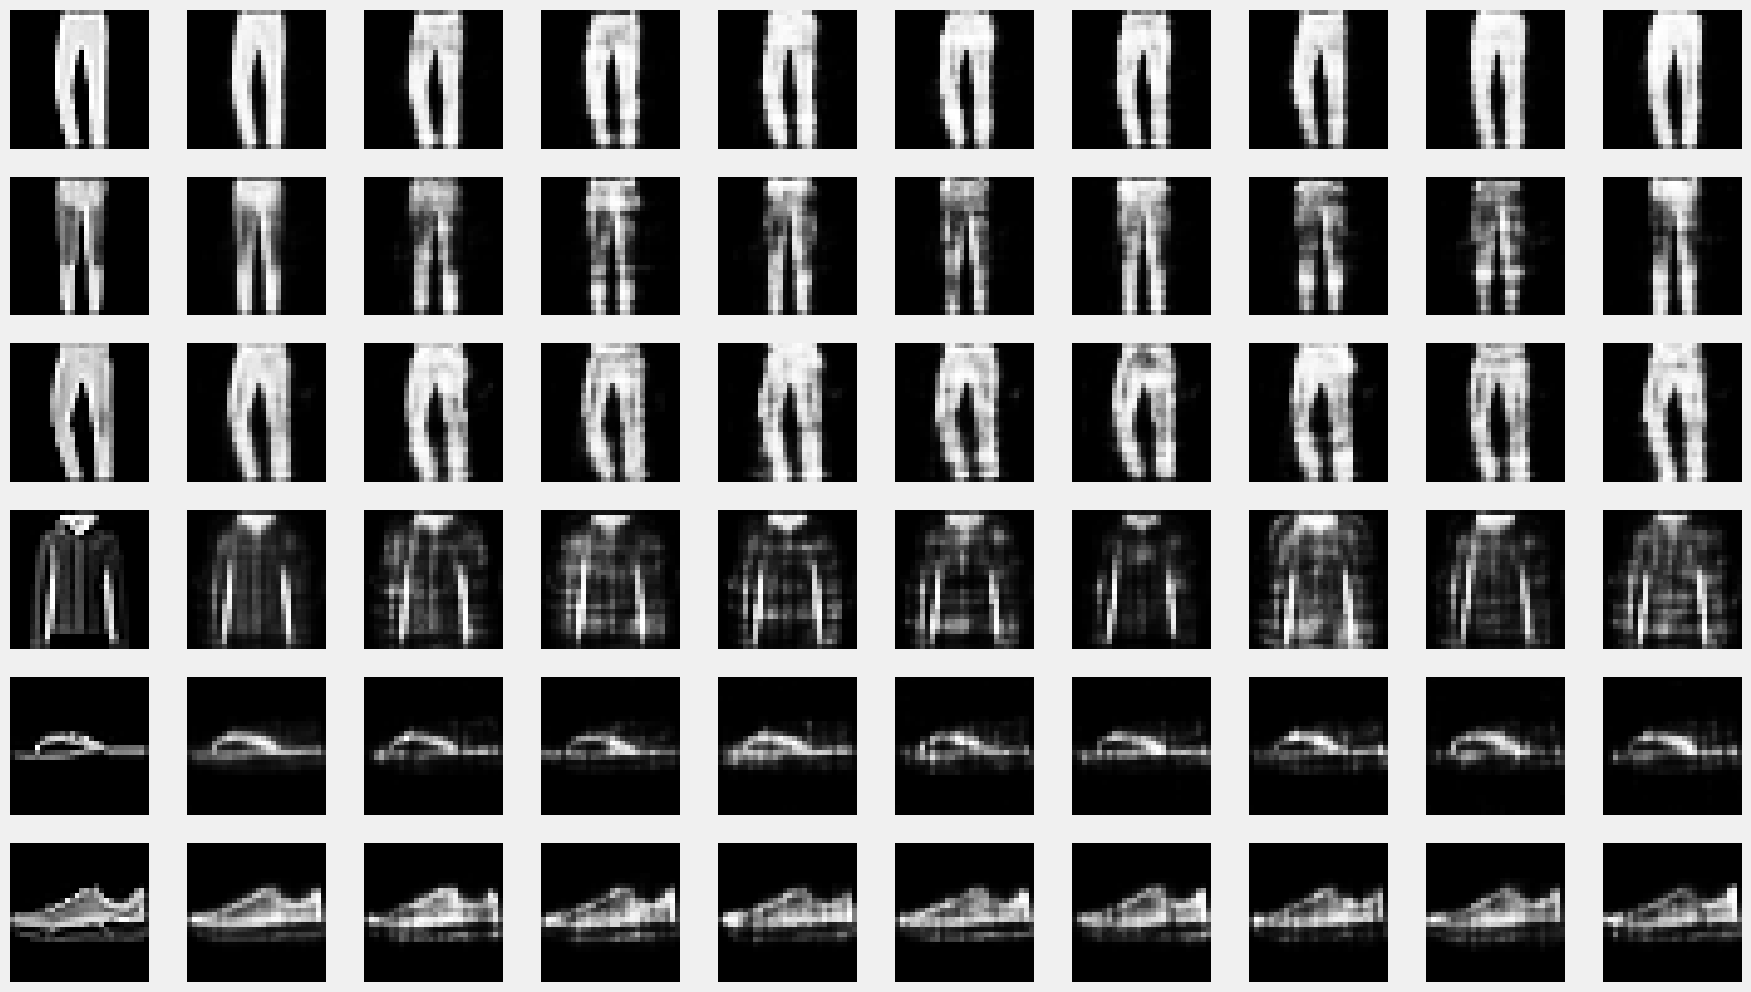

In [81]:
noise_added([testset[i][0] for i in [2,3,5,6,8,9]], lin_model, sigma=0.5)

In [82]:
def generated(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model,"latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(-1,d)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

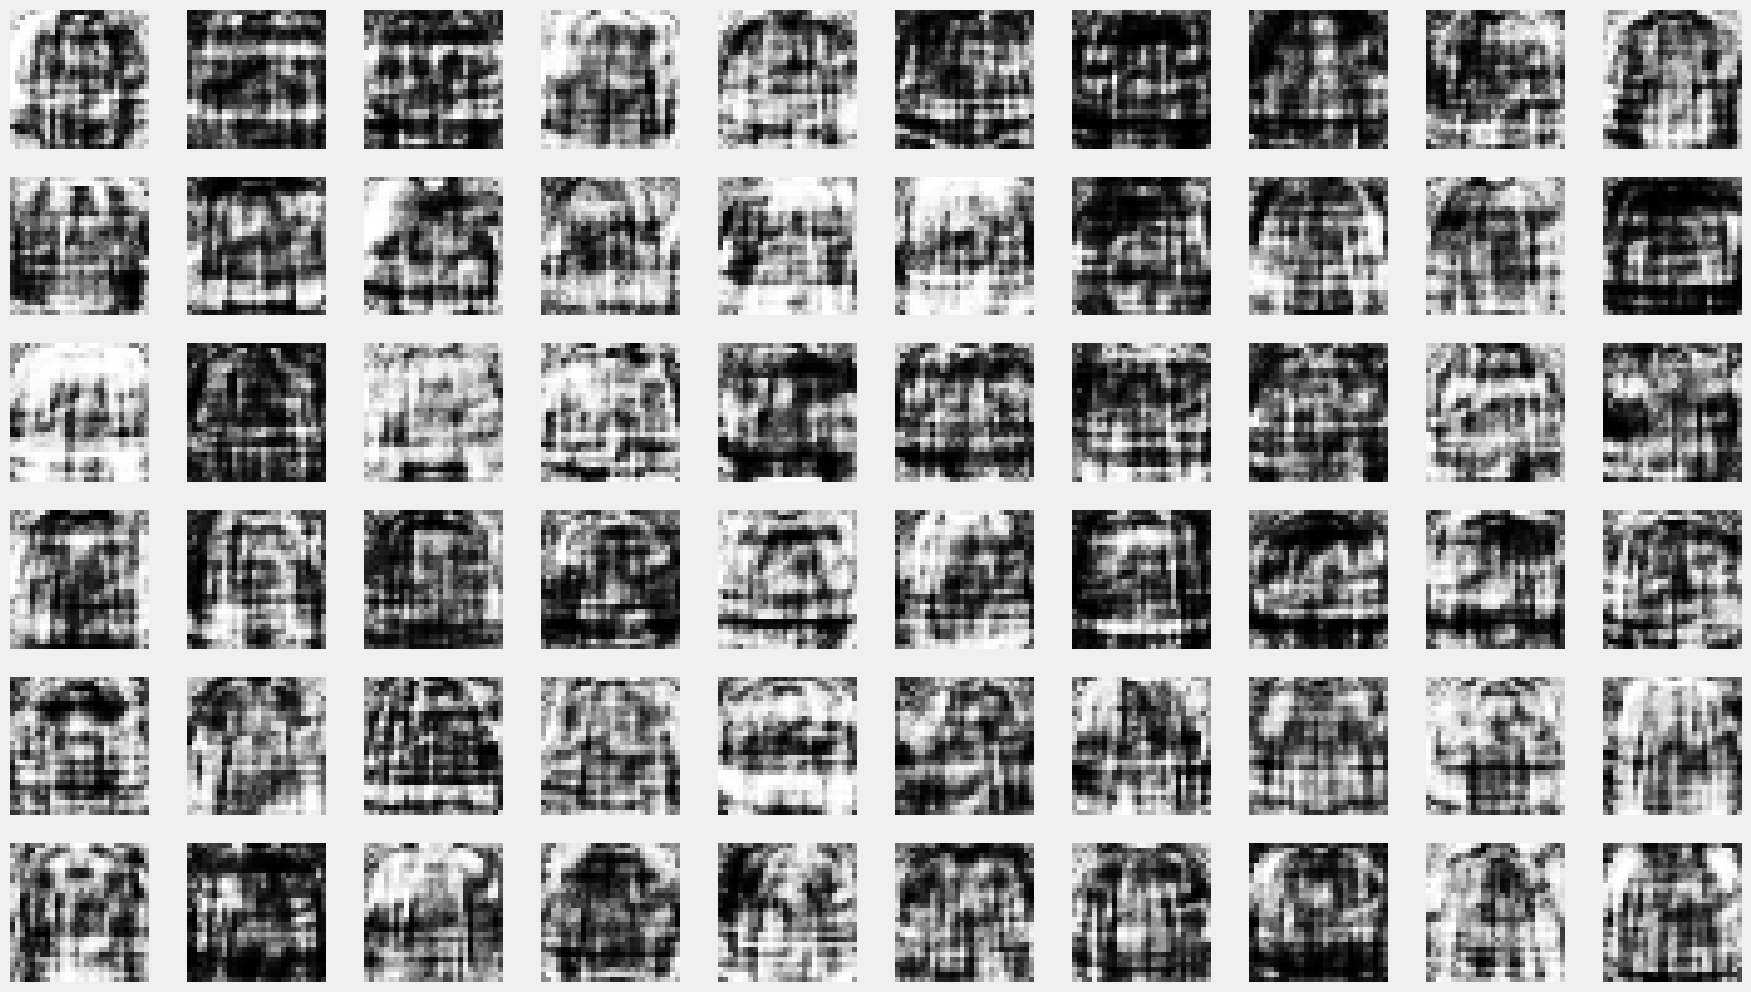

In [83]:
generated(lin_model)

## CNN

In [84]:
class AECNN1(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # YOUR CODE
        self.d = latent_dim//4
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=self.d, kernel_size=3, stride=2),
            torch.nn.Flatten()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.d, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=1),
            torch.nn.Sigmoid()
        )
        # YOUR CODE
  
    def forward(self, x):
        # YOUR CODE
        x = x.view(-1,1,28,28)
        z = self.encoder(x)   
        z = z.view(-1, self.d, 2,2)
        reconstruced = self.decoder(z)
        return reconstruced
                
        # YOUR CODE
    

In [85]:
epochs = 5
lr = 0.001
model = AECNN1(128)
pelosses2, pelosses_test2 = train_eval(epochs, lr, model, loader, testloader)

Epoch 0: 0.0205  0.0131
Epoch 1: 0.0111  0.0099
Epoch 2: 0.0090  0.0083
Epoch 3: 0.0078  0.0073
Epoch 4: 0.0070  0.0069


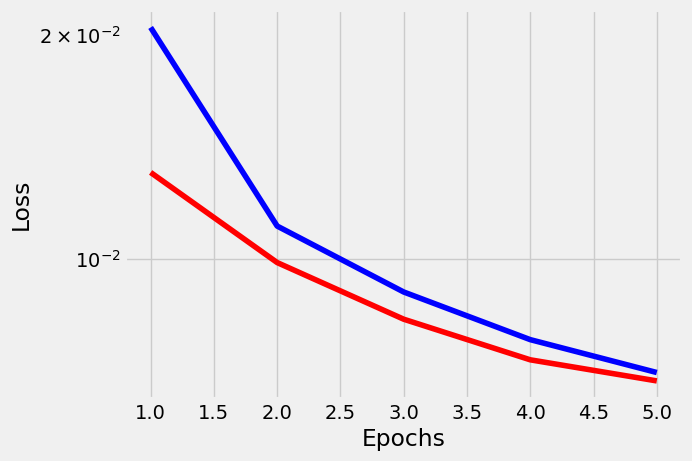

In [86]:
plot_loss(pelosses2, pelosses_test2)

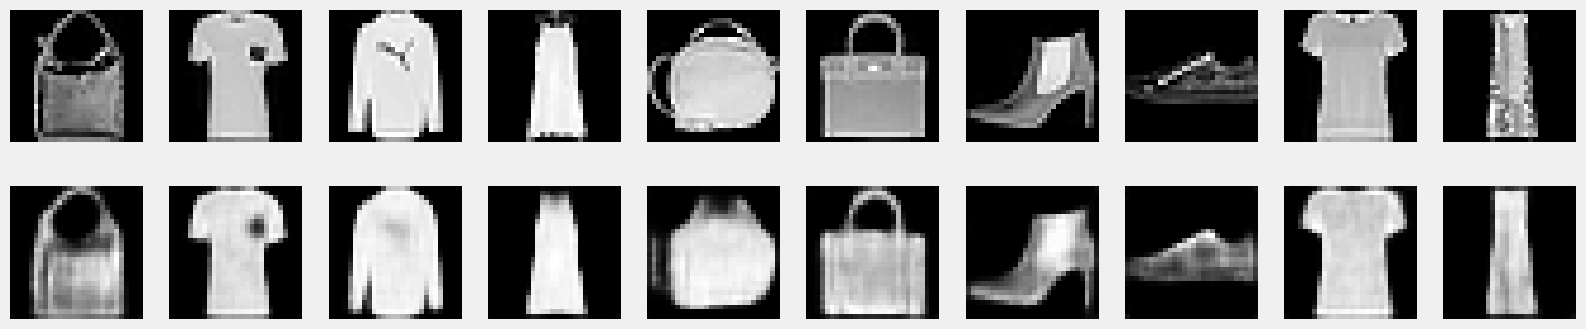

In [87]:
plot_samples(testset, [model])

In [88]:
def generated4cnn(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model,"latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(d//4,2,2)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

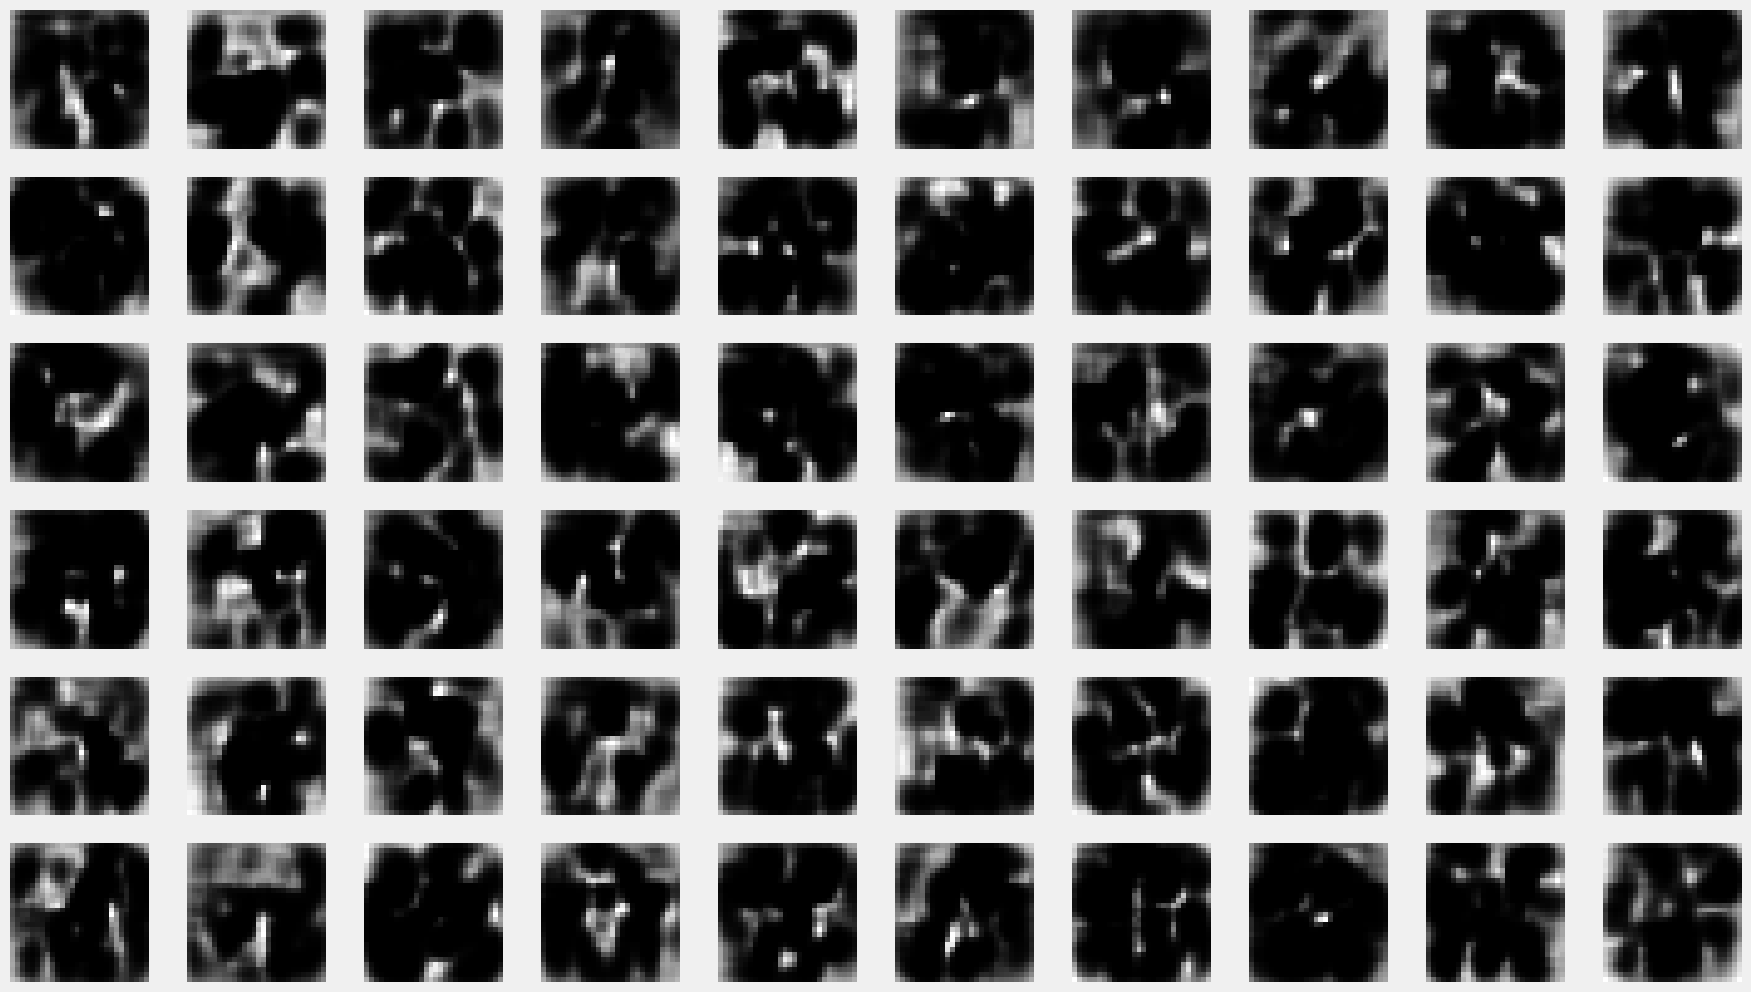

In [89]:
generated4cnn(model, 128)

In [90]:
def noise_added4cnn(inputs, model, ld, sigma=0.2):
    n = 10
    m = len(inputs)
    to_plot = {}
    model = model.to("cpu")
    for j in range(m):
        img = inputs[j]
        z = model.encoder(img).view(-1, ld//4, 2,2)
        rec = model.decoder(z)    
        imgs = [img.detach().numpy(), rec.detach().numpy()]
        for i in range(n-2):
            noise = sigma*torch.randn((ld)).view(ld//4,2,2)
            img_dist = model.decoder(z+noise).detach().numpy()
            imgs.append(img_dist)        
        to_plot[j] = imgs
        
    plt.figure(figsize=(20, m*2))
    ax = plt.subplot(m, n, 1)
    for j in range(m):
        for i in range(n):
            ax = plt.subplot(m, n, j*n+i+1)
            plot_img(to_plot[j][i].reshape(28,28), "")
        
    plt.show()

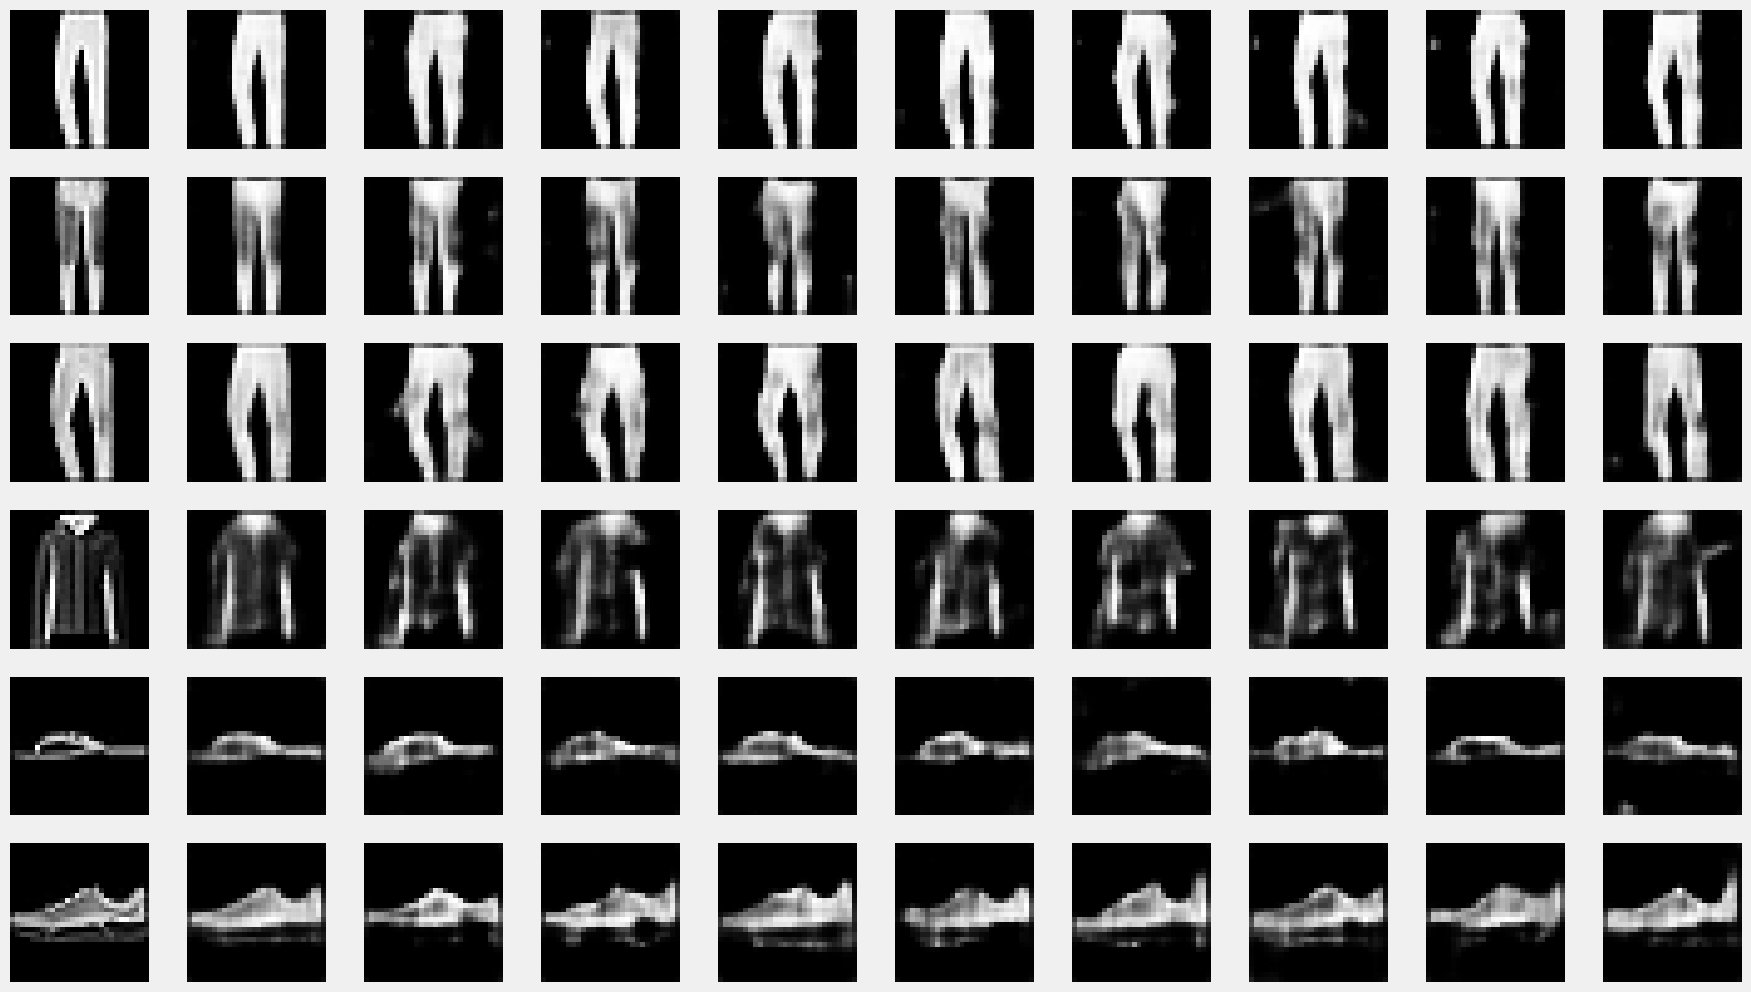

In [91]:
noise_added4cnn([testset[i][0] for i in [2,3,5,6,8,9]], model, 128, sigma=2)

In [92]:
def interpolate4cnn(img1, img2, model, d):
    n = 20
    lrow = int(n/2)
    
    model = model.to("cpu")

    z1 = model.encoder(img1)
    
    z1 = z1.view(-1, d//4, 2,2)
    rec1 = model.decoder(z1)
    
    z2 = model.encoder(img2)
    z2 = z2.view(-1, d//4, 2,2)
    rec2 = model.decoder(z2)
    
    imgs = [img1.detach().numpy(), rec1.detach().numpy()]
    for i in range(n-4):
        z = z1 + (z2-z1)*i/(n-4)
        img_dist = model.decoder(z).detach().numpy()
        imgs.append(img_dist)

    imgs.append(rec2.detach().numpy())
    imgs.append(img2.detach().numpy())

    plt.figure(figsize=(18, 4))
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1)
        plot_img(imgs[i].reshape(28,28), "")
    
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1 + lrow)
        plot_img(imgs[lrow+i].reshape(28,28), "")

plt.show()

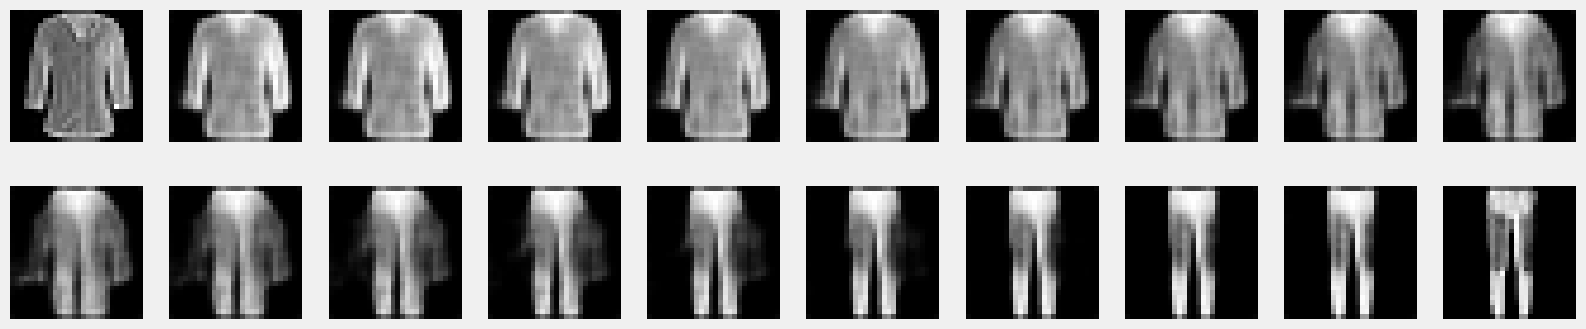

In [93]:
interpolate4cnn(testset[4][0], testset[3][0], model, 128)

### Conclusions
- CNN has better test performance
- Drawing random samples from both leads to rather cryptic images, however at least some clothing patterns can be recognized in images generated by the Linear Network
- The CNN is more robust to noise added to the latent space
- The interpolation for Linear layers looks more like the given images fading in/out, whereas with the CNN model the shapes are morphing into eachother.

## VAE

In [4]:
class VAECNN2(torch.nn.Module): 
    def __init__(self, latent_dim, beta=1.0):
        super().__init__()

        self.d = latent_dim//4
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=self.d, kernel_size=3, stride=2),
            torch.nn.Flatten()
        )

        # conv + flatten: (32, 2, 2) = 128 
        self.mean_layer = torch.nn.Linear(128, latent_dim) 
        self.logvar_layer = torch.nn.Linear(128, latent_dim)

        self.decoder = torch.nn.Sequential(
            # decoder
            torch.nn.ConvTranspose2d(in_channels=self.d, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=1),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device) # sample    
        z = mean + var*epsilon
        return z

    def decode(self, z):
        z = z.view(-1, self.d, 2,2)
        return self.decoder(z)
    
    def forward(self, x):
        x = x.view(-1,1,28,28)
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_ = self.decode(z)
        return x_, mean, logvar
                

    def reconstruct(self, x): 
        # Just take the mu as z (without sampling) for single image (1, 28, 28)
        x = x.view(-1,1,28,28)
        mean, _ = self.encode(x)
        z = mean
        x_ = self.decode(z)
        return x_


    def loss(self, rec, img, mean, logvar):
        # Compute the total loss (per batch): Reconstruction Loss + KL Loss
        
        rec_loss = torch.linalg.norm((rec-img)).pow(2)
        KL_loss =  0.5 * torch.sum(logvar.exp() + mean.pow(2) - 1 - logvar)
        
        loss = rec_loss + KL_loss
        return loss, rec_loss, KL_loss
        

In [5]:
def train_eval_vae(epochs, lr, model, loader, testloader, decay_lr=0.9):
    pelosses = []
    pelosses_rec = []
    pelosses_kl = []
    pelosses_test = []
    pelosses_test_rec = []
    pelosses_test_kl = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_lr)
    
    for epoch in range(epochs):    
        peloss = 0.0
        peloss_rec = 0.0
        peloss_kl = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed, mean, logvar = model(image)  
            loss, recloss, klloss = model.loss(reconstructed, image, mean, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
            peloss_rec += recloss.item()
            peloss_kl += klloss.item()
        peloss /= len(loader)
        peloss_rec /= len(loader)
        peloss_kl /= len(loader)
        pelosses.append(peloss)
        pelosses_rec.append(peloss_rec)
        pelosses_kl.append(peloss_kl)
        
        scheduler.step()
    
        testpeloss = 0.0
        testpeloss_rec = 0.0
        testpeloss_kl = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed, mean, logvar = model(image)  
                loss, recloss, klloss = model.loss(reconstructed, image, mean, logvar)
                testpeloss += loss.item()
                testpeloss_rec += recloss.item()
                testpeloss_kl += klloss.item()
            testpeloss /= len(testloader)
            testpeloss_rec /= len(testloader)
            testpeloss_kl /= len(testloader)
            pelosses_test.append(testpeloss)
            pelosses_test_rec.append(testpeloss_rec)
            pelosses_test_kl.append(testpeloss_kl)
        print("Epoch %i: %6.4f  %6.4f %6.4f %6.4f %6.4f %6.4f"%(epoch, peloss, peloss_rec, peloss_kl, testpeloss, testpeloss_rec, testpeloss_kl))
    return pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl


In [8]:
epochs = 5
lr = 0.001
vae = VAECNN2(128)
pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl \
                                        = train_eval_vae(epochs, lr, vae, loader, testloader,decay_lr=1.0)

Epoch 0: 620.0803  602.5067 17.5736 10882.1475 10581.7978 300.3498
Epoch 1: 307.5790  299.4119 8.1671 8749.6843 8539.8341 209.8502
Epoch 2: 258.9483  252.4460 6.5022 7655.0757 7460.2136 194.8621
Epoch 3: 232.2221  226.5639 5.6581 7106.1992 6932.0404 174.1588
Epoch 4: 213.0039  207.9342 5.0698 6498.3437 6344.2711 154.0725


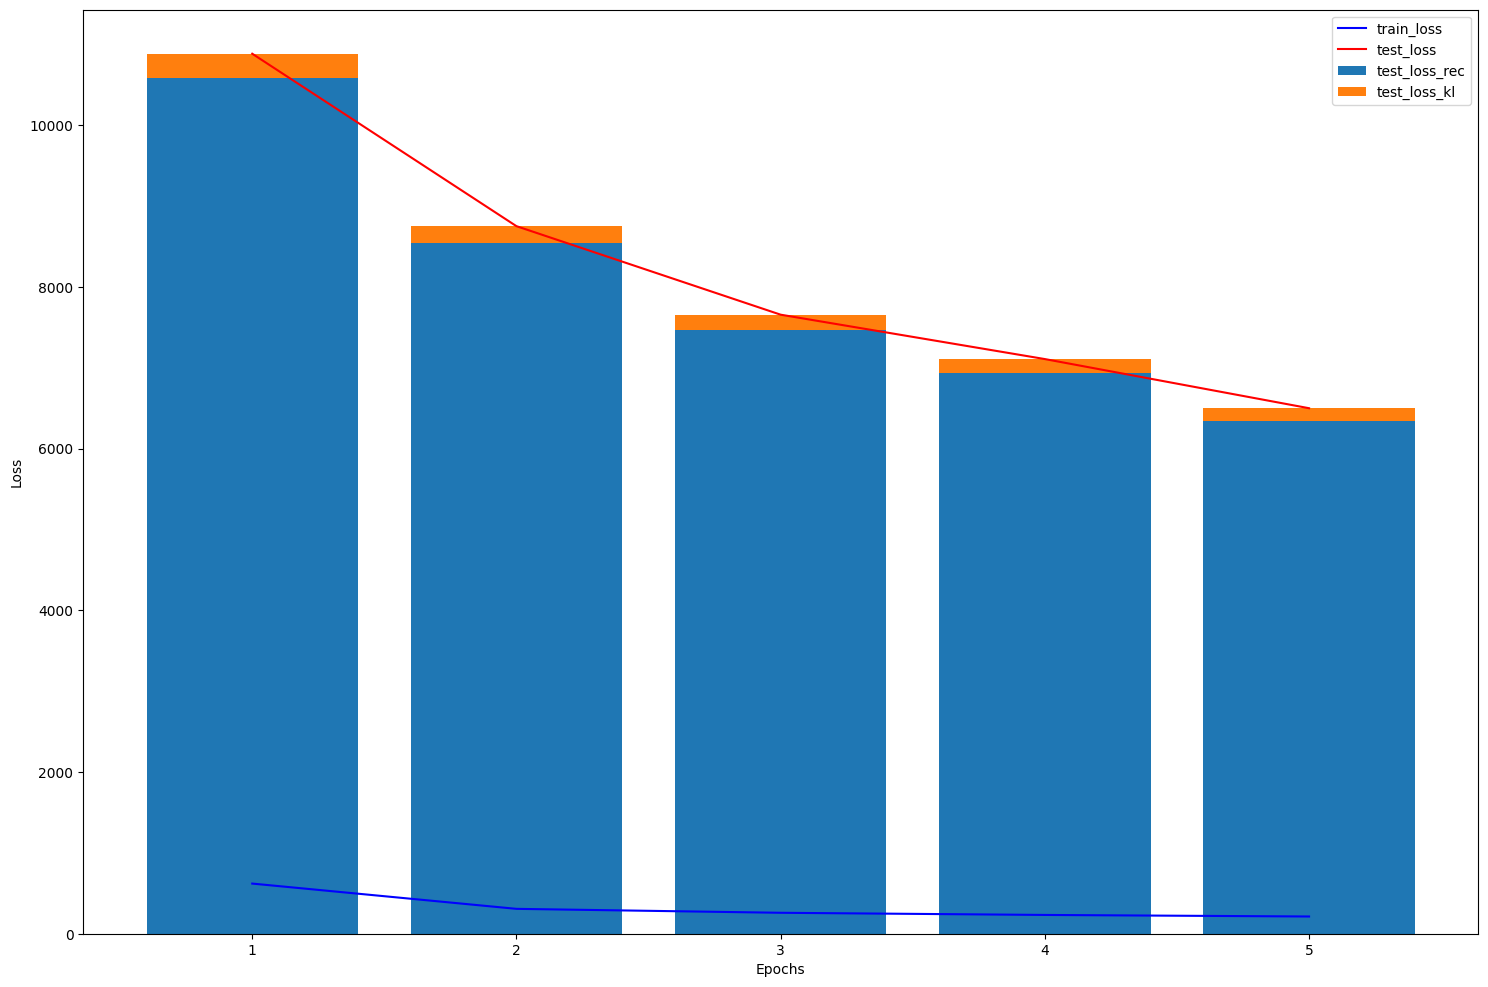

In [9]:
plt.figure(figsize=(18,12))
plt.xlabel('Epochs')
plt.ylabel('Loss')
epochs = len(pelosses)
plt.plot(torch.arange(epochs)+1, pelosses, 'b-', label="train_loss")
plt.plot(torch.arange(epochs)+1, pelosses_test, 'r-',label="test_loss")    
plt.bar(torch.arange(epochs)+1, pelosses_test_rec, label="test_loss_rec")
plt.bar(torch.arange(epochs)+1, pelosses_test_kl, bottom=pelosses_test_rec, label="test_loss_kl")
plt.legend()

#### Note on scale of loss

This loss is much higher in magnitude than what we saw in the plain autoencoder training, where standard the MSE was used as a loss function. The reconstruction error seen here, is essentially the mean squared error without taking the mean by deviding by the N components of the tensor. The image tensors are of shape (32,1,28,28), so `N = 25'088`.

Below the chart is redrawn so `test_rec_loss` is scaled up by `N` to resemble the MSE seen before in the plain autoencoderapplication.

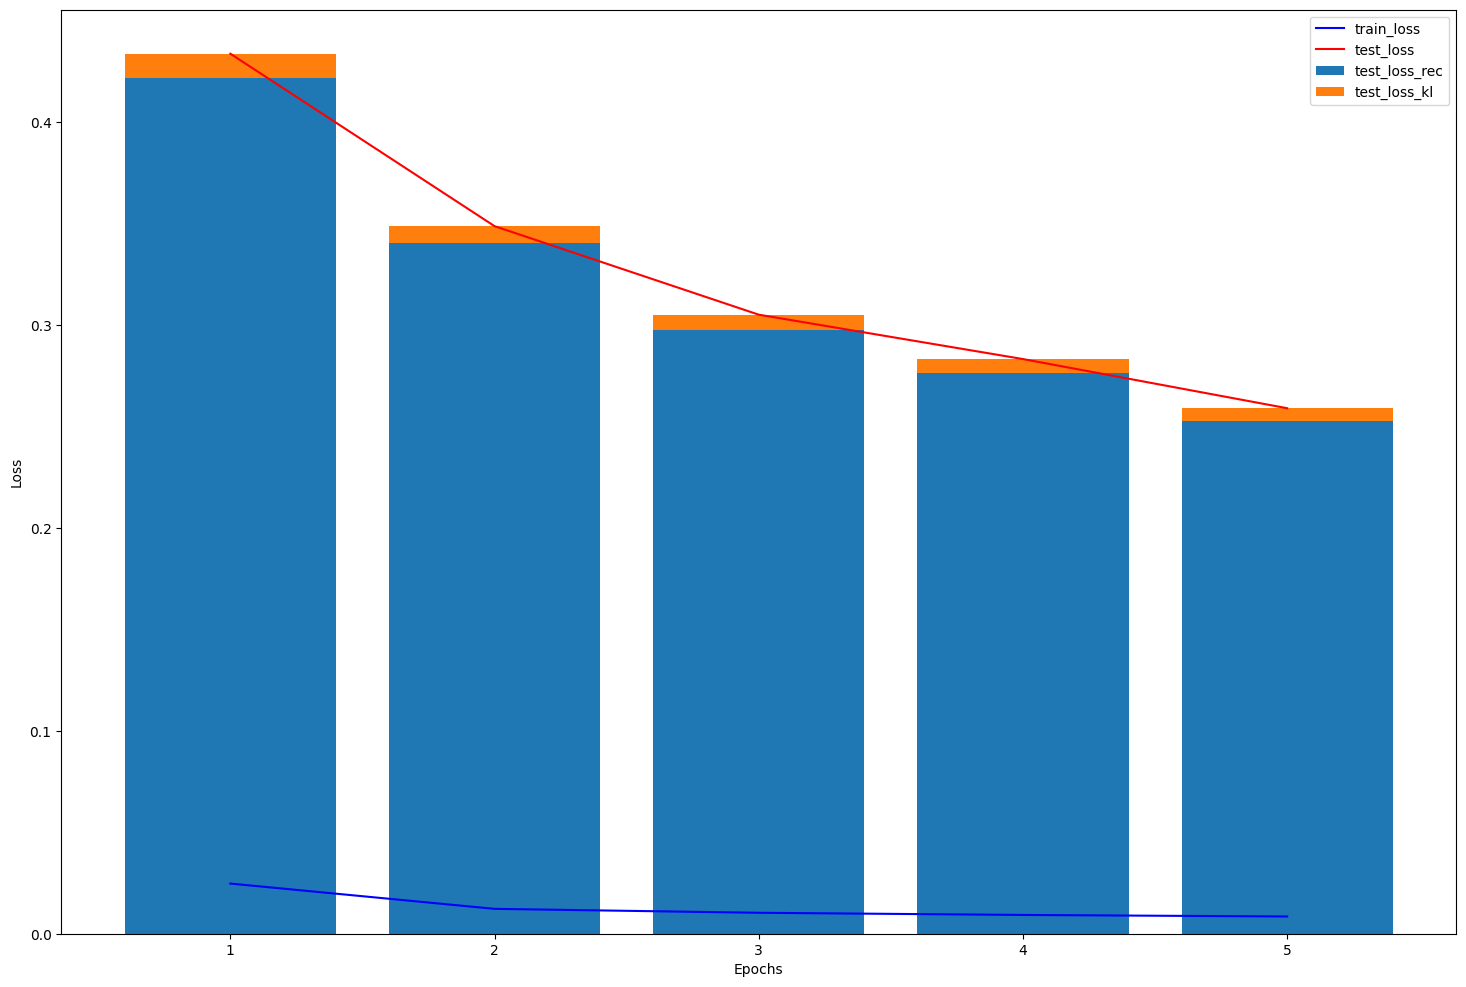

In [15]:
import numpy as np
N=25088

plt.figure(figsize=(18,12))
plt.xlabel('Epochs')
plt.ylabel('Loss')
epochs = len(pelosses)
plt.plot(torch.arange(epochs)+1, np.array(pelosses)/N, 'b-', label="train_loss")
plt.plot(torch.arange(epochs)+1, np.array(pelosses_test)/N, 'r-',label="test_loss")    
plt.bar(torch.arange(epochs)+1, np.array(pelosses_test_rec)/N, label="test_loss_rec")
plt.bar(torch.arange(epochs)+1, np.array(pelosses_test_kl)/N, bottom=np.array(pelosses_test_rec)/N, label="test_loss_kl")
plt.legend()

#### Note on scaled loss
Loss still around 2 orders of magnitude higher than in plain autoencoder application. Something isn't quite right..

In [149]:
def plot_samples_vae(dataset, model):
    n = 10
    m = 1
    model.to("cpu")
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        figure.add_subplot(rows, cols, n+i+1)
        img, label = dataset[idx]
        img = model.reconstruct(img).detach().numpy()
        plot_img(img, "")    
    plt.show()

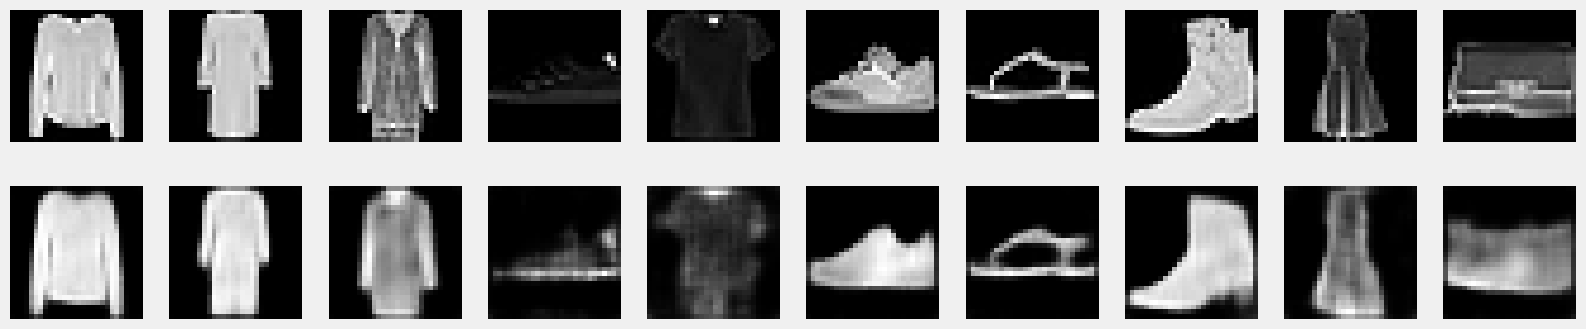

In [167]:
plot_samples_vae(testset, vae)

In [165]:
def generated_vae(model):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((128,)).view(-1,model.d,2,2)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

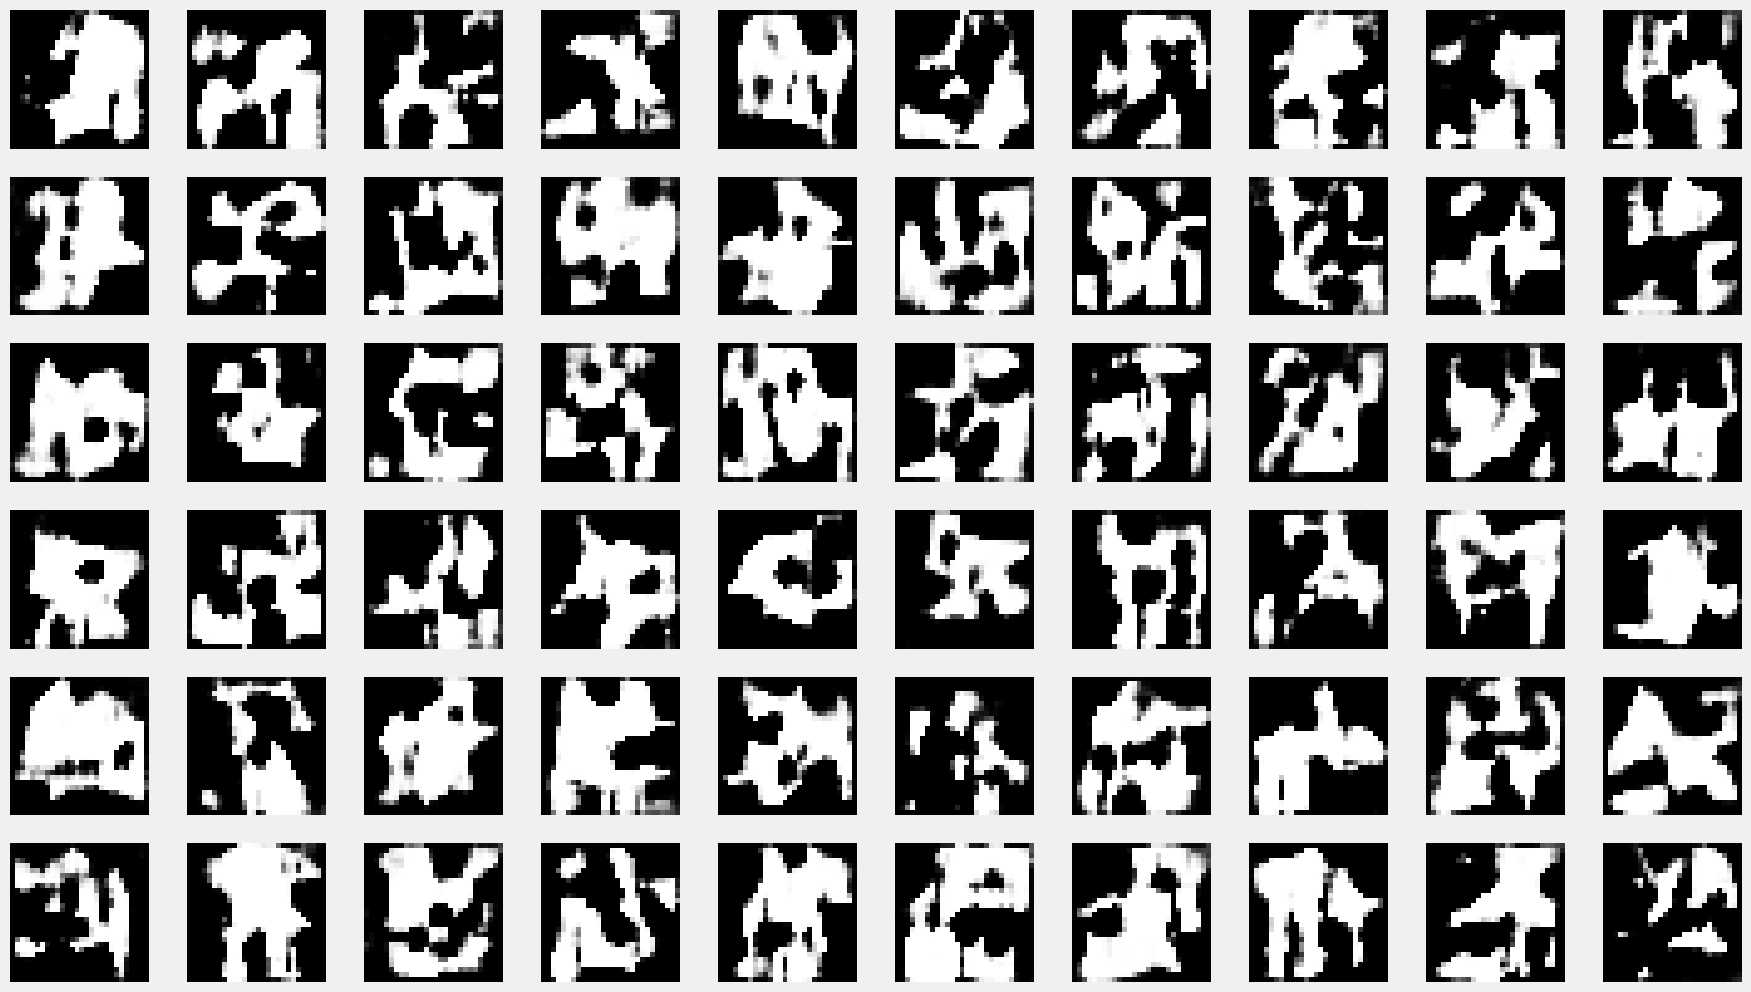

In [166]:
generated_vae(vae)